# INSTALL DEPENDENCIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
colorImg = cv2.imread(r'../../Downloads/download.png')
grayImgBGR = cv2.imread(r'../../Downloads/puppy.jpeg', cv2.IMREAD_GRAYSCALE)

/home/linuxbrew/.linuxbrew/opt/python@3.12/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/linuxbrew/.linuxbrew/opt/python@3.12/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


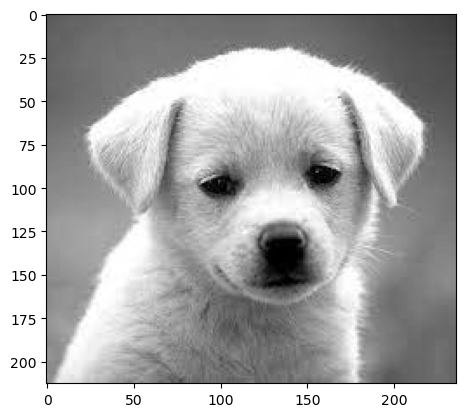

In [3]:
plt.imshow(grayImgBGR, cmap='gray')

213 236


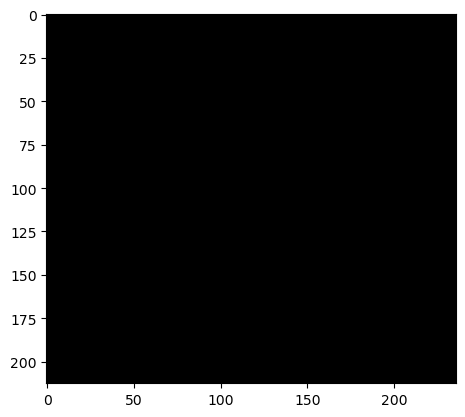

In [4]:
numRows = grayImgBGR.shape[0]
numCols = grayImgBGR.shape[1]
print(numRows, numCols)
grayImgBGR_2 = np.zeros((numRows, numCols))
plt.imshow(grayImgBGR_2, cmap="gray")

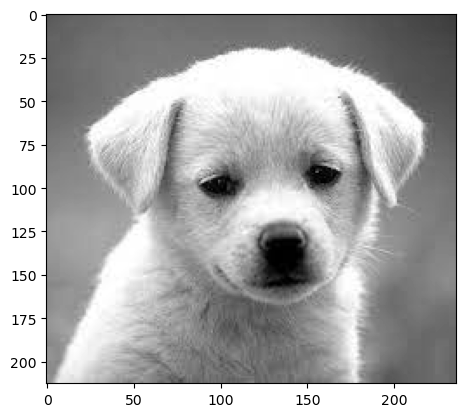

In [5]:
for i in range(numRows):
    for j in range(numCols):
        grayImgBGR_2[i,j] = grayImgBGR[i,j]
plt.imshow(grayImgBGR_2, cmap='gray')

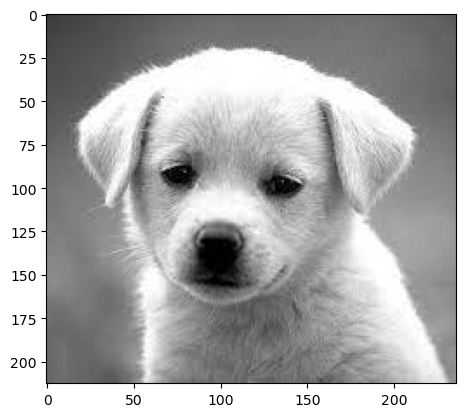

In [6]:
for i in range(numRows):
    for j in range(numCols):
        grayImgBGR_2[i,j] = grayImgBGR[(i),numCols-j-1]
plt.imshow(grayImgBGR_2, cmap='gray')

In [106]:
import matplotlib as mpl
def displayImageInActualSize(img):
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    plt.show

def displayImageInActualSizeColor(img):
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape[0:2]
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img)
    plt.show

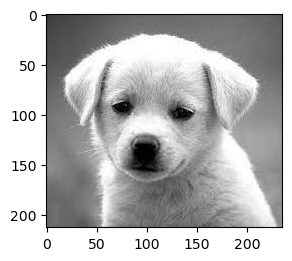

In [87]:
displayImageInActualSize(grayImgBGR_2)

In [88]:
S = np.array([[2,0],[0,2]])
I2 = np.zeros((2 * numRows, 2 * numCols), dtype='uint8')
for i in range(numRows):
    for j in range(numCols):
        P = np.array([i, j])
        P_dash = S.dot(P)
        new_i, new_j = P_dash[0], P_dash[1]
        I2[new_i, new_j] = grayImgBGR[i, j]
print(I2.shape)

(426, 472)


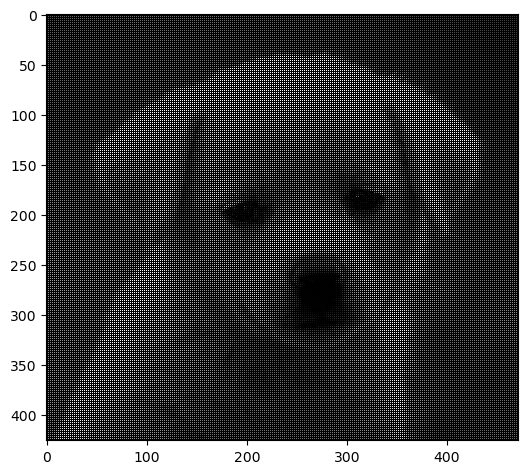

In [89]:
displayImageInActualSize(I2)

In [90]:
p = np.array([2,4])
Sx, Sy = 2, 0.1
s = np.array([[Sx, 1], [1, Sy]])
P_ = s.dot(p)
print(P_)

[8.  2.4]


# INVERSE SCALING

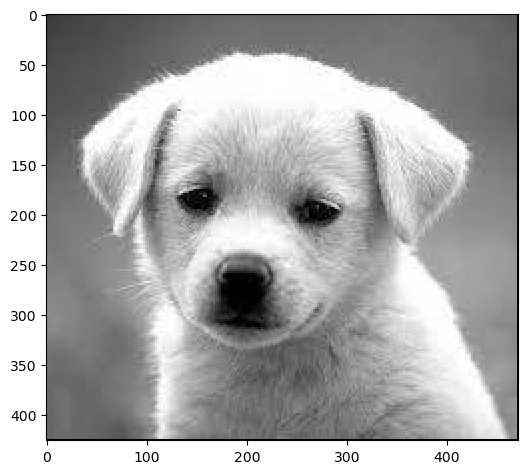

In [70]:
S = np.array([[2,0],[0,2]])
I2 = np.zeros((S[0][0] * numRows, S[1][1] * numCols), dtype='uint8')
Tinv = np.linalg.inv(S)
for new_i in range(I2.shape[0]):
    for new_j in range(I2.shape[1]):
        P_dash = np.array([new_i, new_j])
        P = Tinv.dot(P_dash)
        P = np.int16(np.ceil(P))
        i, j = P[0], P[1]
        if i<0 or i>=numRows or j<0 or j >= numCols:
            pass
        else:
            I2[new_i, new_j] = grayImgBGR_2[i,j]

displayImageInActualSize(I2)

In [71]:
I2 = np.ones((S[0][0] * numRows, S[1][1] * numCols), dtype='uint8') * 256

In [72]:
I2

array([[256, 256, 256, ..., 256, 256, 256],
       [256, 256, 256, ..., 256, 256, 256],
       [256, 256, 256, ..., 256, 256, 256],
       ...,
       [256, 256, 256, ..., 256, 256, 256],
       [256, 256, 256, ..., 256, 256, 256],
       [256, 256, 256, ..., 256, 256, 256]], dtype=uint16)

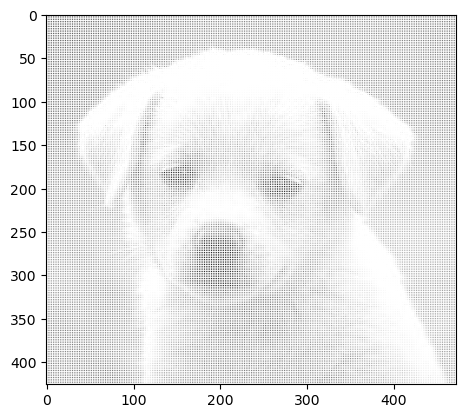

In [75]:
for i in range(numRows):
    for j in range(numCols): 
        P = np.array([i, j])
        P_dash = S.dot(P)
        new_i, new_j = P_dash[0], P_dash[1]
        I2[new_i, new_j] = grayImgBGR_2[i, j]
plt.imshow(I2, cmap='gray')

# BILINEAR TRANSFORMATION

In [76]:
def f_bilinearInterpolate(row, col, I):
    leftCol = int(col)
    rightCol = leftCol + 1
    widthLeft = col - leftCol
    widthRight = rightCol - col
    topRow = int(row)
    bottomRow = topRow + 1
    widthTop = row - topRow
    widthBottom = bottomRow - row
    if topRow >= 0 and bottomRow < I.shape[0] and leftCol >= 0 and rightCol < I.shape[1]:
        a = I[topRow, leftCol] * widthRight + I[topRow, rightCol] * widthLeft
        b = I[bottomRow, leftCol] * widthRight + I[bottomRow, rightCol] * widthLeft
        g = widthTop * b + widthRight * a
        return np.uint8(g)
    else:
        return 0

In [77]:
def scalingMatrix(scale):
    size = len(scale)
    matrix = np.zeros((size, size))
    for i,_ in enumerate(matrix):
        matrix[i][i] = scale[i]
    return matrix

In [114]:
def f_scaleImage(scale, Img):
    numRows = Img.shape[0]
    numCols = Img.shape[1]
    S = scalingMatrix(scale)
    I = np.zeros((int(scale[0]) * numRows, int(scale[1]) * numCols), dtype='uint8')
    Tinv = np.linalg.inv(S)
    for new_i in range(I.shape[0]):
        for new_j in range(I.shape[1]):
            P_dash = np.array([new_i, new_j])
            P = Tinv.dot(P_dash)
            #P = np.int16(np.floor(P))
            i, j = P[0], P[1]
            if i<0 or i>=numRows or j<0 or j >= numCols:
                pass
            else:
                g = f_bilinearInterpolate(i, j, Img)
                I[new_i, new_j] = g
    return I

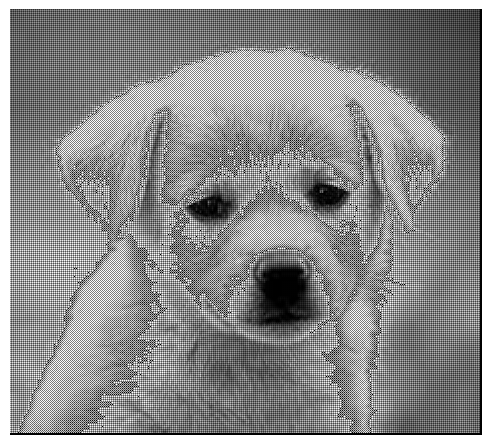

In [115]:
displayImageInActualSize(f_scaleImage([2,2], grayImgBGR))

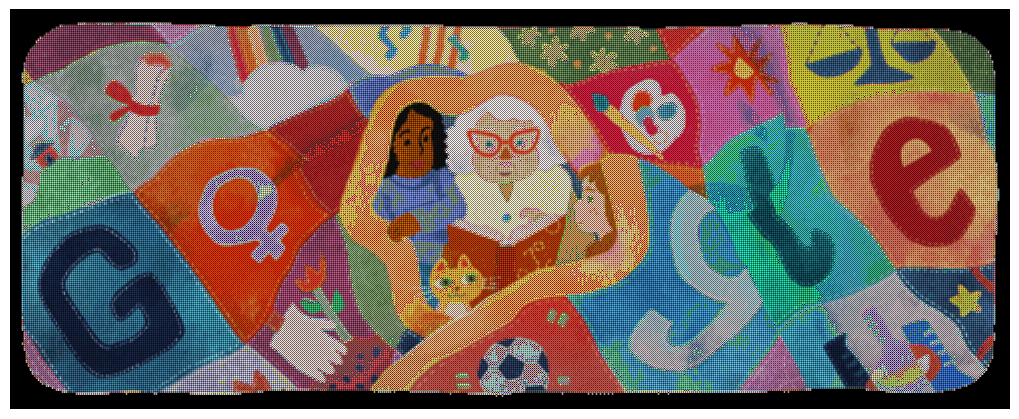

In [124]:
ImgClr = colorImg[:,:,::-1]
scale = [2,2]
r = f_scaleImage(scale, ImgClr[:,:,0])
g = f_scaleImage(scale, ImgClr[:,:,1])
b = f_scaleImage(scale, ImgClr[:,:,2])
C = np.zeros((r.shape[0], r.shape[1], 3), dtype=np.uint8)
C[:,:,0] = r
C[:,:,1] = g
C[:,:,2] = b
displayImageInActualSizeColor(C)
